## D. Unsupervised learning on Fashion-MNIST

Fashion-MNIST is a dataset of Zalando's article images, with examples shown above. It consists of a
training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28
grayscale image, associated with a label from 10 classes: 0=T-shirt/top; 1=Trouser; 2=Pullover;
3=Dress; 4=Coat; 5=Sandal; 6=Shirt; 7=Sneaker; 8=Bag; 9=Ankle boot.
<br><br>
Choose any two out of the 10 classes and use only the test data for these two chosen classes to
complete tasks in this section. It will be better to finish reading the remaining part of this section
before choosing the two classes. Again, you may choose any two and there is no “correct” answer
about which two to choose but some choices may make your studies below more interesting than
others.

## D1. Dimentionality Reduction and Clustering [7 Marks]
A) Apply PCA to all images of these two chosen classes. Visualise the top 5 eigenvectors as
images and display them in the order of descending corresponding values (the one
corresponding to the largest eigenvalue first).<br>
B) Use the top 30 PCs to reconstruct 10 images, with 5 from each class (any 5 images are fine
from each class). Show these 10 pairs of reconstructed and original images.<br>
C) Visualise the two-dimensional PCA representations of all data points in a 2D plane (i.e. using
the top two PCs). Use different colours/markers for the two classes for better visualisation
(Hint: You need to use the class labels here for visualisation). <br>
D) Use spectral clustering to cluster all data points as represented by the top two PCs (clustering of two-dimensional vectors, where each vector has two values, PC1 and PC2). Visualise the two clusters with different colours/markers in 2D. <br>
E) Design a new autoencoder with five Conv2d layers and five ConvTranspose2d layers. You arefree to choose the activation functions and settings such as stride and padding. Train this new autoencoder on all images of these two chosen classes for at least 20 epochs. Plot the loss against the epoch.

In [25]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [26]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
x_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [28]:
y_test[:5]

array([9, 2, 1, 1, 6], dtype=uint8)

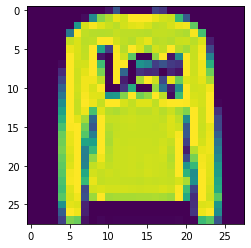

In [29]:
img_index = 1
plt.imshow(x_test[img_index])

Selecting first two categories i.e. 0=T-shirt/top; 1=Trouser

In [30]:
index = np.where(y_test <= 1)
y_test = y_test[index]
x_test = x_test[index]
y_test.shape, y_test.shape

((2000,), (2000,))

Normalize the data

In [48]:
X_scaled = x_test/255
y_scaled = y_test/255

In [50]:
X_scaled= X_scaled.reshape(len(x_test), 28*28)
X_scaled.shape

(2000, 784)


### A) Apply PCA to all images of these two chosen classes. Visualise the top 5 eigenvectors as images and display them in the order of descending corresponding values (the one corresponding to the largest eigenvalue first).

In [51]:
from sklearn.decomposition import PCA

# Initialize PCA object
pca = PCA()

# Fit PCA to normalized data with no components
fitted = pca.fit_transform(X_scaled)

# Cumulative explained variance
cum_exp_variance = np.cumsum(pca.explained_variance_)

# Print first 5 PCs' cumulative explained variance
# Should we print the the explained variances or the cumulative explained variances?

# Return the pca object for further use
print(f"First 5 PCs: {pca.explained_variance_[:5]}")

First 5 PCs: [16.04724889  6.93266635  2.00238937  1.63968501  1.47209451]


In [52]:
pca.components_[0:5].shape

(5, 784)

### Visualizing the top 5 eigenvectors as images

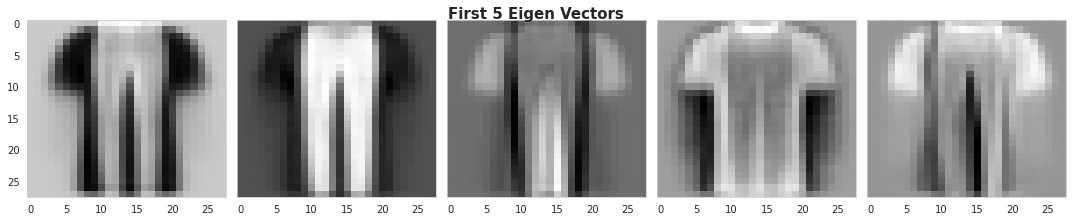

In [64]:
sns.set_style("whitegrid", {'axes.grid' : False})

# Plot the grid of images
fig, axes = plt.subplots(1,5, figsize = (15,3), sharex=True, sharey = True )

# top 5 eigenvectors
f_5_ev = [i.reshape(28,28) for i in pca.components_[0:5]]

for j in range(0,5):
    axes[j].imshow(f_5_ev[j], aspect='auto', cmap = "gray_r")


fig.suptitle("First 5 Eigen Vectors", y=1.01, fontweight = 'bold', fontsize='15')
plt.tight_layout()
plt.show()

### B) Use the top 30 PCs to reconstruct 10 images, with 5 from each class (any 5 images are fine from each class). Show these 10 pairs of reconstructed and original images.

In [62]:
def reconstruction(X, n, trans):
    """
    Creates a reconstruction of an input record, X, using the topmost (n) vectors from the
    given transformation (trans)
    
    Note 1: In this dataset each record is the set of pixels in the image (flattened to 
    one row).
    Note 2: X should be normalized before input.
    """
    vectors = [trans.components_[n] * X[n] for n in range(0, n)]
    
    # Invert the PCA transformation.
    ret = trans.inverse_transform(X)
    
    # This process results in non-normal noise on the margins of the data.
    # We clip the results to fit in the [0, 1] interval.
    ret[ret < 0] = 0
    ret[ret > 1] = 1
    return ret

def n_sample_reconstructions(X, n_samples=5, trans_n=30, trans=None):
    """
    Returns a tuple with `n_samples` reconstructions of records from the feature matrix X,
    as well as the indices sampled from X.
    """
    sample_indices = np.round(np.random.random(n_samples)*len(X))
    return (sample_indices, 
            np.vstack([reconstruction(X[int(ind)], trans_n, trans) for ind in sample_indices]))


def plot_reconstructions(X, n_samples=5, trans_n=30, trans=None):
    """
    Plots `n_samples` reconstructions.
    """
    fig, axarr = plt.subplots(n_samples, 3, figsize=(12, n_samples*4))
    ind, reconstructions = n_sample_reconstructions(X, n_samples, trans_n, trans)
    for (i, (ind, reconstruction)) in enumerate(zip(ind, reconstructions)):
        ax0, ax1, ax2 = axarr[i][0], axarr[i][1], axarr[i][2]
        sns.heatmap(X_scaled[int(ind), :].reshape(28, 28), cmap='gray_r', ax=ax0)
        sns.heatmap(reconstruction.reshape(28, 28), cmap='gray_r', ax=ax1)
        sns.heatmap(np.abs(X_scaled[int(ind), :] - reconstruction).reshape(28, 28), 
                    cmap='gray_r', ax=ax2)
        ax0.axis('off')
        ax0.set_aspect('equal')
        ax0.set_title("Original Image", fontsize=12)
        ax1.axis('off')
        ax1.set_aspect('equal')
        ax1.set_title("30-Vector Reconstruction", fontsize=12)
        ax2.axis('off')
        ax2.set_title("Original-Reconstruction Difference", fontsize=12)
        ax2.set_aspect('equal')

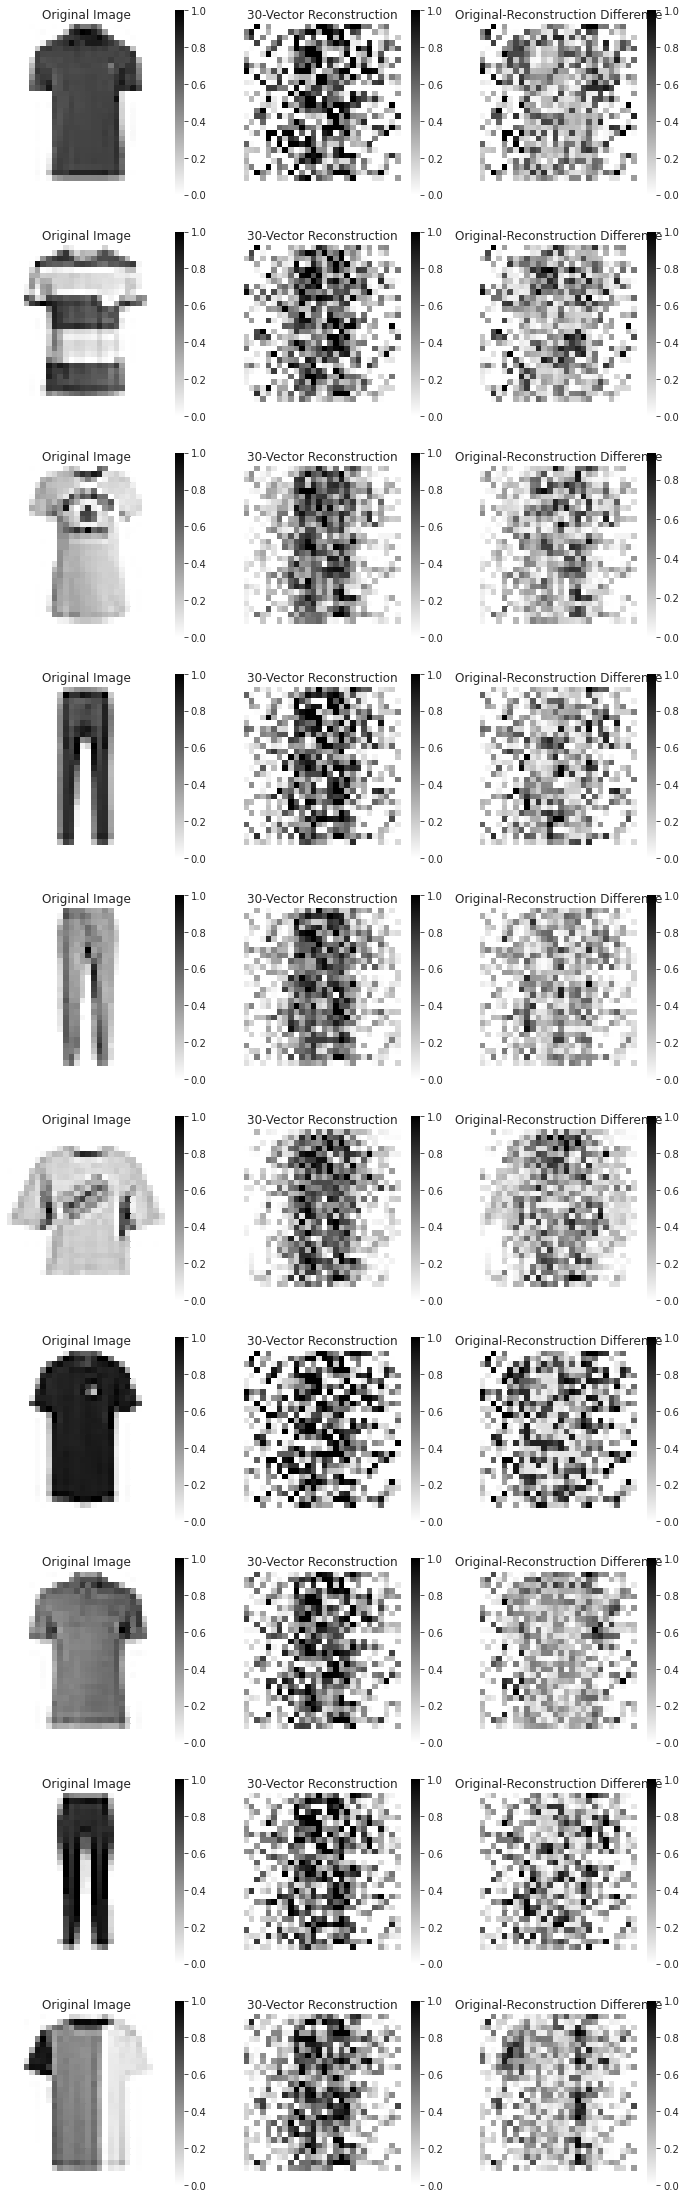

In [63]:
plot_reconstructions(X_scaled, n_samples=10, trans_n=30, trans=pca)

### C) Visualise the two-dimensional PCA representations of all data points in a 2D plane (i.e. usingthe top two PCs). Use different colours/markers for the two classes for better visualisation (Hint: You need to use the class labels here for visualisation).

In [12]:
top2PC = fitted[:,[0,1]]

In [13]:
# creating a new data frame with top two PCs
dataframe = pd.DataFrame(data=top2PC, columns=("1st_principal", "2nd_principal"))
dataframe["label"] = y
print(dataframe.head())

   1st_principal  2nd_principal  label
0      -2.834116      -3.758336      1
1      -4.601639      -0.375558      1
2      -1.431211      -1.273275      1
3      -3.739086      -0.421800      1
4       6.031457      -0.794064      0


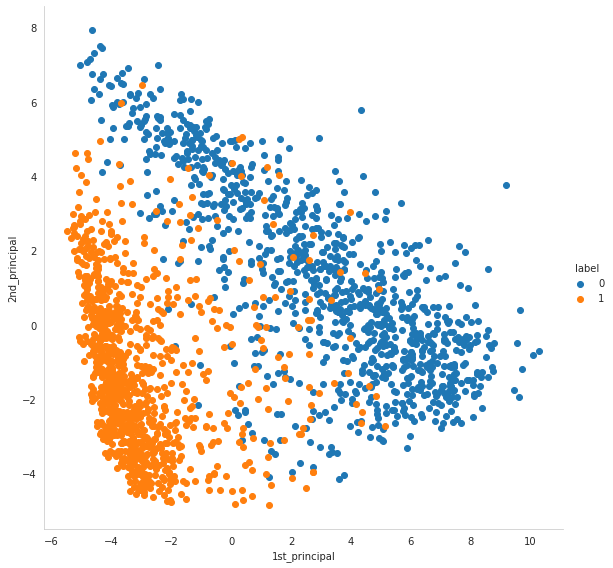

In [14]:
# ploting the 2d data points with seaborn
import seaborn as sn
sn.FacetGrid(dataframe, hue="label", height=8).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

### D) Use spectral clustering to cluster all data points as represented by the top two PCs (clustering of two-dimensional vectors, where each vector has two values, PC1 and PC2). Visualise the two clusters with different colours/markers in 2D.

In [15]:
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import SpectralClustering

In [16]:
# Building the clustering model
spectral_model_rbf = SpectralClustering(n_clusters = 2, affinity ='rbf')
  
# Training the model and Storing the predicted cluster labels
labels_rbf = spectral_model_rbf.fit_predict(top2PC)

No handles with labels found to put in legend.


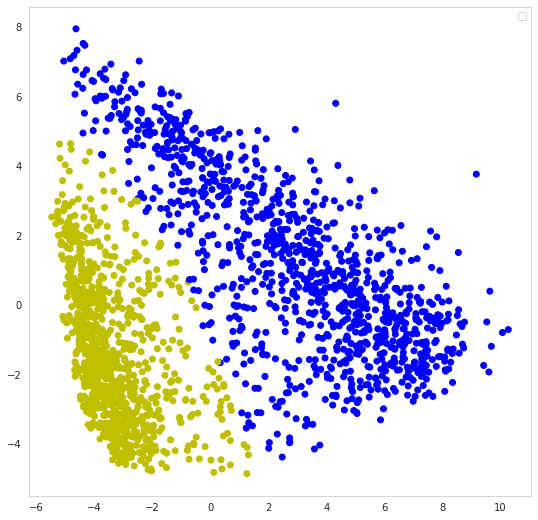

In [17]:
# Building the label to colour mapping
colours = {}
colours[0] = 'b'
colours[1] = 'y'
  
# Building the colour vector for each data point
cvec = [colours[label] for label in labels_rbf]
  
# Plotting the clustered scatter plot
  
plt.figure(figsize =(9, 9))
plt.scatter(dataframe['1st_principal'], dataframe['2nd_principal'], c = cvec)
plt.legend()
plt.show()

### E) Design a new autoencoder with five Conv2d layers and five ConvTranspose2d layers. You arefree to choose the activation functions and settings such as stride and padding. Train this new autoencoder on all images of these two chosen classes for at least 20 epochs. Plot the loss against the epoch.

In [31]:
test_images  = x_test.reshape(-1,28,28,1)
test_images = test_images/255
test_images = test_images.astype(np.float32)

In [32]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(test_images,
                                                             test_images,
                                                             test_size=0.2,
                                                             random_state=42)

In [42]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = tf.keras.layers.Input(shape = (x, y, inChannel))
num_classes = 2

In [43]:
from tensorflow.keras.layers import Conv2D , Conv2DTranspose, BatchNormalization, MaxPool2D


In [44]:
def encoder(input_img):

  #input: 28*28*1
  conv1 = Conv2D(32,(3,3), activation='relu', padding='same')(input_img) #28*28*32
  conv1 = BatchNormalization()(conv1)
  pool1 = MaxPool2D(pool_size=(2,2))(conv1)#14*14*32

  conv2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool1)#14*14*64
  conv2 = BatchNormalization()(conv2)
  pool2 = MaxPool2D(pool_size=(2,2))(conv2)#7*7*64

  conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool2)#7*7*128
  conv3 = BatchNormalization()(conv3)

  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)#7*7*256
  conv4 = BatchNormalization()(conv4)

  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
  encoded = BatchNormalization()(conv5)

  return encoded

def decoder(encoded):
  conv6 = Conv2D(256, (3,3), activation='relu', padding='same')(encoded)#7*7*256
  conv6 = BatchNormalization()(conv6)
  up1 = Conv2DTranspose(256, (3, 3),  padding='same')(conv6)

  # conv7 = Conv2D(256, (3,3), activation='relu', padding='same')(up1)#7*7*128
  conv7 = BatchNormalization()(up1)
  up2 = Conv2DTranspose(256, (3, 3),  padding='same')(conv7)

  # conv8 = Conv2D(128, (3,3), activation='relu', padding='same')(up2)#7*7*128
  conv8 = BatchNormalization()(up2)
  up3 = Conv2DTranspose(128, (3, 3),  padding='same')(conv8)#14*14*128

  conv9 = Conv2D(64, (3,3), activation='relu', padding='same')(up3)#14*14*64
  conv9 = BatchNormalization()(conv9)
  up4 = Conv2DTranspose(64,(3, 3), strides=2, padding='same')(conv9)#28*28*64

  conv10 = Conv2D(64, (3,3), activation='relu', padding='same')(up4)#14*14*64
  conv10 = BatchNormalization()(conv10)
  up5 = Conv2DTranspose(32,(3, 3), strides=2, padding='same')(conv10)#28*28*64

  conv11 = Conv2D(32, (3,3), activation='relu', padding='same')(up5)#28*28*32
  conv11 = BatchNormalization()(conv11)
  decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(conv11)#28*28*1

  return decoded

In [45]:
autoencoder = tf.keras.Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))
autoencoder.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_116 (Conv2D)         (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_118 (Ba  (None, 28, 28, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_117 (Conv2D)         (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_119 (Ba  (None, 14, 14, 64)       256

In [46]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/50
13/13 [==============================] - 5s 149ms/step - loss: 0.1379 - val_loss: 0.2481
Epoch 2/50
13/13 [==============================] - 1s 103ms/step - loss: 0.0583 - val_loss: 0.1330
Epoch 3/50
13/13 [==============================] - 1s 104ms/step - loss: 0.0593 - val_loss: 0.1284
Epoch 4/50
13/13 [==============================] - 1s 103ms/step - loss: 0.0432 - val_loss: 0.0981
Epoch 5/50
13/13 [==============================] - 1s 103ms/step - loss: 0.0455 - val_loss: 0.1023
Epoch 6/50
13/13 [==============================] - 1s 104ms/step - loss: 0.0345 - val_loss: 0.1048
Epoch 7/50
13/13 [==============================] - 1s 102ms/step - loss: 0.0324 - val_loss: 0.1395
Epoch 8/50
13/13 [==============================] - 1s 103ms/step - loss: 0.0303 - val_loss: 0.0745
Epoch 9/50
13/13 [==============================] - 1s 108ms/step - loss: 0.0272 - val_loss: 0.0790
Epoch 10/50
13/13 [==============================] - 1s 104ms/step - loss: 0.0253 - val_loss: 0.0750

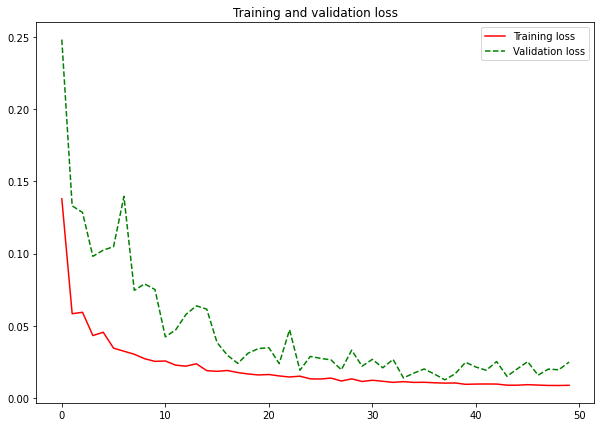

In [47]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(50)
plt.figure(figsize=(10,7))
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'g--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## D2. Observations

1. From the figure B) of reconstructed images we can see that first 30 Principal Components are not that much capable of creating adaptive filters that fit the trends in the data. In our case, the first 30 Principal Components does not clearly show both the categories we selected from dataset. May be adding more pricipal components will explain more variance throughout the dataset.
2. From the figure from C) we can see that a compression from 784D to 2D compresses the data too much but still We can clearly see separate clusters for both classes we chose.   